<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/Local_Rounds/qFedAvg/qFederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

## Imports

In [71]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from sklearn.metrics import f1_score

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Sat Apr 24 12:55:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    35W /  70W |   1286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

## Load the MNIST Dataset

In [72]:
torch.cuda.set_device('cuda:0')

In [73]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [74]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [75]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [76]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [77]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


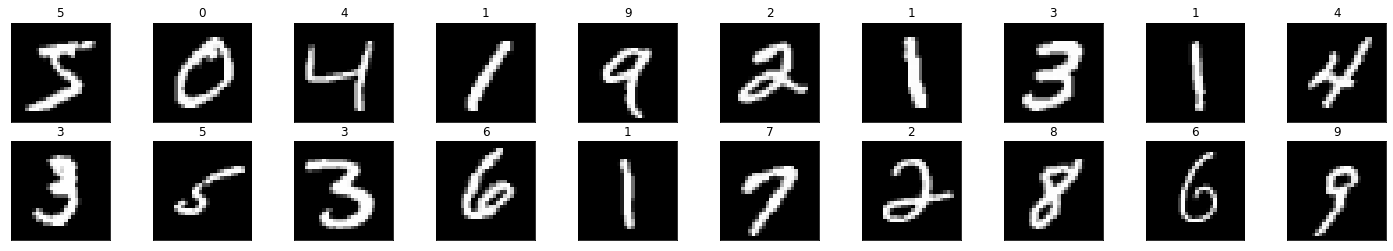

In [78]:
visualize(mnist_data_train)

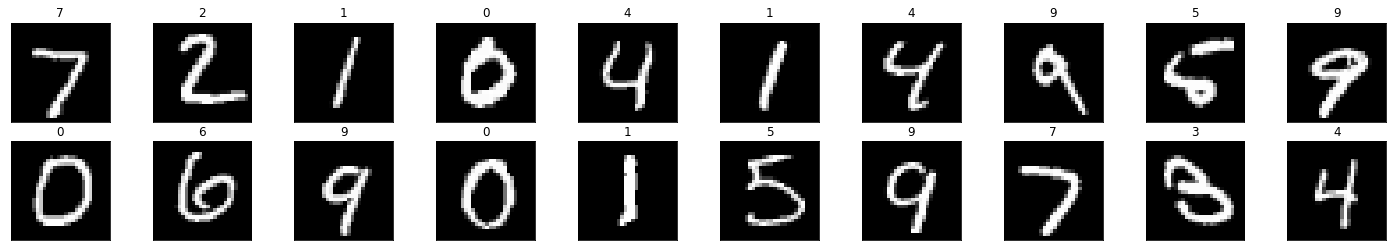

In [79]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [80]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [81]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict


## Models

In [82]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [83]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [84]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## q Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [85]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    e_loss = []

    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

### Server Side Training


In [86]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [87]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, q, sampling, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []
  f1_macro = []
  f1_weighted = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))

    global_weights = model.state_dict()

    for k in range(len(S_t)):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

    # Perform qFedAvg
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current, f1_macro_current, f1_weighted_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)
    f1_macro.append(f1_macro_current)
    f1_weighted.append(f1_weighted_current)

  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_macro)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Macro',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Marco.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_weighted)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Weighted',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Weighted.jpg', format='jpg')
  plt.show()

  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end_time-start_time))
  
  return model, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted

## Testing Loop

In [88]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(test_loader):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    for i, lbl in enumerate(labels.data):
      try:
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)
  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))

    print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))
  
  return test_accuracy, test_loss, f1_macro, f1_weighted

## Logger

In [89]:
log_dict = {}
NUM_REPEAT = 1

## MNIST CNN on IID

### Train


In [90]:
# train_loss_multiple_runs = [None] * NUM_REPEAT
# test_accuracy_multiple_runs = [None] * NUM_REPEAT
# test_loss_multiple_runs = [None] * NUM_REPEAT
# f1_macro_multiple_runs = [None] * NUM_REPEAT
# f1_weighted_multiple_runs = [None] * NUM_REPEAT

# for exp_num in range(NUM_REPEAT):
#   print("Experiment Run Number: ", exp_num)

#   # number of training rounds
#   rounds = 50
#   # client fraction
#   C = 0.5
#   # number of clients
#   K = 100
#   # number of training passes on local dataset for each roung
#   E = 5
#   # batch size
#   batch_size = 10
#   # learning Rate
#   lr=0.05
#   # fairness
#   q = 0.001
#   # sampling
#   # sampling = 'uniform'
#   sampling = 'weighted'
#   # data partition dictionary
#   iid_dict = iid_partition(mnist_data_train, 100)
#   # load model
#   mnist_cnn = MNIST_CNN()

#   if torch.cuda.is_available():
#     mnist_cnn.cuda()

#   mnist_cnn_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, iid_dict, C, K, E, q, sampling, "MNIST CNN on IID Dataset", "orange")

#   train_loss_multiple_runs[exp_num] = train_loss
#   test_accuracy_multiple_runs[exp_num] = test_accuracy
#   test_loss_multiple_runs[exp_num] = test_loss
#   f1_macro_multiple_runs[exp_num] = f1_macro
#   f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [91]:
# criterion = nn.CrossEntropyLoss()
# acc, loss, f1_macro, f1_weighted = testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

In [92]:
# hyperparams = {'rounds': rounds,
#                'C': C,
#                'K': K,
#                'E': E,
#                'batch_size': batch_size,
#                'lr': lr,
#                'q': q,
#                'sampling': sampling
#                }

# log_dict['MNIST CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
#                                 'test_loss': test_loss_multiple_runs, 
#                                 'test_accuracy': test_accuracy_multiple_runs,
#                                 'f1_macro': f1_macro_multiple_runs,
#                                 'f1_weighted': f1_weighted_multiple_runs,
#                                 'hyperparams': hyperparams,
#                                 }

## MNIST CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1 Picking 10/100 clients: [49 39 21 37 98 72 29 60 24 61]
Round: 1... 	Average Loss: 0.32
Round: 2 Picking 10/100 clients: [89 55 73 45 52 69 81 65 97 76]
Round: 2... 	Average Loss: 0.156
Round: 3 Picking 10/100 clients: [84 28 43 56 46  2 20 88  5 23]
Round: 3... 	Average Loss: 0.091
Round: 4 Picking 10/100 clients: [35 75 56 95 22 87 28 24 49  7]
Round: 4... 	Average Loss: 0.072
Round: 5 Picking 10/100 clients: [38 35 16 86 98 89 19 50 60 80]
Round: 5... 	Average Loss: 0.057
Round: 6 Picking 10/100 clients: [88 62  3 48 71 87 67  4 96 91]
Round: 6... 	Average Loss: 0.052
Round: 7 Picking 10/100 clients: [12 11 53 75 38 13 51 33 35 64]
Round: 7... 	Average Loss: 0.046
Round: 8 Picking 10/100 clients: [88 55 68 65 31 37 91 82 56 90]
Round: 8... 	Average Loss: 0.043
Round: 9 Picking 10/100 clients: [88 92 22 71 60 73 26 69 40 83]
Round: 9... 	Average Loss: 0.037
Round: 10 Picking 10/100 clients: [79 21 18 71 55 75 85 23 83 88]
Round: 10... 	Average Loss:

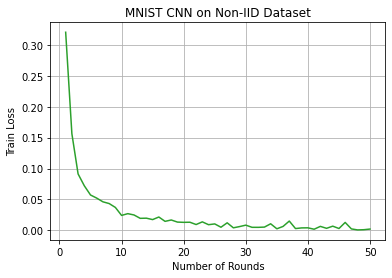

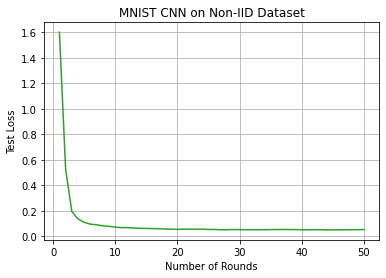

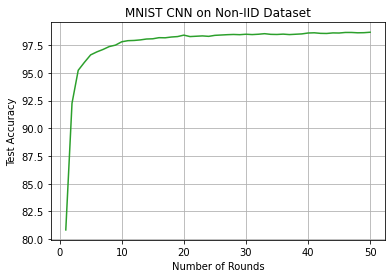

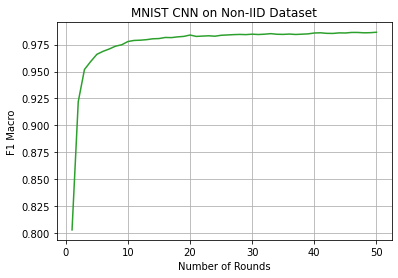

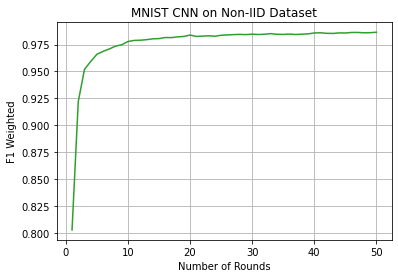

Training Done!
Total time taken to Train: 619.1506669521332




In [93]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train,100, 1000, 60, 10)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [94]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.054303

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 98% (1019/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 98% (881/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 98% (958/974)
Test Accuracy of     9: 96% (977/1009)

Final Test  Accuracy: 98.650 (9865/10000)
F1 Score: 0.986439 (macro) 0.986492 (weighted) %



In [95]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on IID

### Train

In [96]:
# train_loss_multiple_runs = [None] * NUM_REPEAT
# test_accuracy_multiple_runs = [None] * NUM_REPEAT
# test_loss_multiple_runs = [None] * NUM_REPEAT
# f1_macro_multiple_runs = [None] * NUM_REPEAT
# f1_weighted_multiple_runs = [None] * NUM_REPEAT

# for exp_num in range(NUM_REPEAT):
#   print("Experiment Run Number: ", exp_num)

#   # number of training rounds
#   rounds = 50
#   # client fraction
#   C = 0.5
#   # number of clients
#   K = 100
#   # number of training passes on local dataset for each round
#   E = 5
#   # batch size
#   batch_size = 10
#   # learning Rate
#   lr=0.05
#   # fairness
#   q = 0.001
#   # sampling
#   # sampling = 'uniform'
#   sampling = 'weighted'
#   # dict containing different type of data partition
#   data_dict = iid_partition(mnist_data_train, 100)
#   # load model
#   mnist_mlp = MNIST_2NN()

#   if torch.cuda.is_available():
#     mnist_mlp.cuda()

#   mnist_mlp_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST MLP on IID Dataset", "orange")
  
#   train_loss_multiple_runs[exp_num] = train_loss
#   test_accuracy_multiple_runs[exp_num] = test_accuracy
#   test_loss_multiple_runs[exp_num] = test_loss
#   f1_macro_multiple_runs[exp_num] = f1_macro
#   f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [97]:
# criterion = nn.CrossEntropyLoss()
# acc, loss, f1_macro, f1_weighted = testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

In [98]:
# hyperparams = {'rounds': rounds,
#                'C': C,
#                'K': K,
#                'E': E,
#                'batch_size': batch_size,
#                'lr': lr,
#                'q': q,
#                'sampling': sampling
#                }

# log_dict['MNIST MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
#                                 'test_loss': test_loss_multiple_runs, 
#                                 'test_accuracy': test_accuracy_multiple_runs,
#                                 'f1_macro': f1_macro_multiple_runs,
#                                 'f1_weighted': f1_weighted_multiple_runs,
#                                 'hyperparams': hyperparams,
#                                 }

## MNIST MLP on Non IID

### Train

Experiment Run Number:  0
Round: 1 Picking 10/100 clients: [62 90 18 43 40 11 16 33 73 15]
Round: 1... 	Average Loss: 0.347
Round: 2 Picking 10/100 clients: [26 67 59 10 94 14  6 30  2  3]
Round: 2... 	Average Loss: 0.164
Round: 3 Picking 10/100 clients: [57 89 40 30 91  6 47 25 38 41]
Round: 3... 	Average Loss: 0.123
Round: 4 Picking 10/100 clients: [54 45 98  2 75  5 43 20 94 72]
Round: 4... 	Average Loss: 0.104
Round: 5 Picking 10/100 clients: [46 95 72 70  7 61 98 21 79 17]
Round: 5... 	Average Loss: 0.083
Round: 6 Picking 10/100 clients: [45  8 34 77  4 32 62 94 24 17]
Round: 6... 	Average Loss: 0.073
Round: 7 Picking 10/100 clients: [20 23 63 99 52 27 74 15  3 60]
Round: 7... 	Average Loss: 0.068
Round: 8 Picking 10/100 clients: [21 39 23 91 33 44  8 51 86 36]
Round: 8... 	Average Loss: 0.059
Round: 9 Picking 10/100 clients: [78  3 23 13 40 89 37 60 35 38]
Round: 9... 	Average Loss: 0.055
Round: 10 Picking 10/100 clients: [ 8 34 74 84 72  0 11 73 94 69]
Round: 10... 	Average Loss

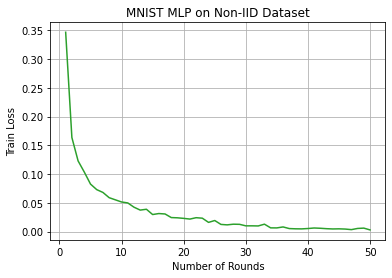

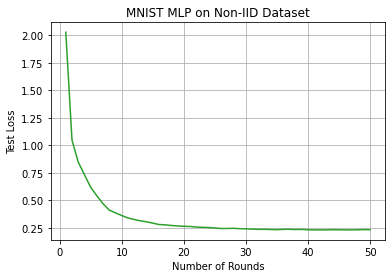

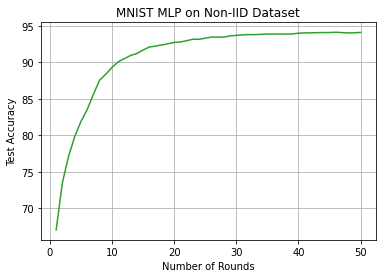

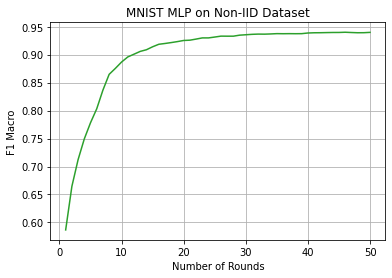

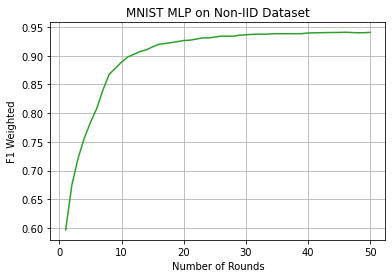

Training Done!
Total time taken to Train: 431.30663228034973




In [99]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.1
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'

  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 1000, 60, 10)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [100]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.233186

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 94% (978/1032)
Test Accuracy of     3: 94% (958/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 87% (777/892)
Test Accuracy of     6: 86% (832/958)
Test Accuracy of     7: 93% (960/1028)
Test Accuracy of     8: 95% (932/974)
Test Accuracy of     9: 92% (930/1009)

Final Test  Accuracy: 94.100 (9410/10000)
F1 Score: 0.939791 (macro) 0.940715 (weighted) %



In [101]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [102]:
import pickle
 
with open(path + 'qFedAvg_10shards.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [103]:
log_dict

{'MNIST CNN on Non IID': {'f1_macro': [[0.8029825720826741,
    0.9220020159780796,
    0.9518745566643105,
    0.9592471202676913,
    0.9659700325931609,
    0.968742872894728,
    0.9709288347295116,
    0.9735145901721036,
    0.9748152014780613,
    0.9778381454630571,
    0.9788351752791264,
    0.9790652105579996,
    0.9795546331760019,
    0.9803649232714367,
    0.980583331116421,
    0.9815731039088316,
    0.9814607397749786,
    0.9821448617542332,
    0.9825937750073879,
    0.9838506078548213,
    0.9825720426170547,
    0.9828662886069232,
    0.9831465690574968,
    0.982765954053033,
    0.983625658959028,
    0.9839197553084944,
    0.9842262192675865,
    0.984409155647796,
    0.9842393032120065,
    0.9846393478651848,
    0.9843395600632053,
    0.9846387365175602,
    0.9851315489517128,
    0.9845662220976605,
    0.9844531716794431,
    0.9847575962589203,
    0.9843800153178062,
    0.9846373118075313,
    0.9849304588693428,
    0.98573477253446,
    0.98592

In [104]:
import pickle

with open(path + 'qFedAvg_10shards.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [ ]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on IID']['test_accuracy']])

In [106]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on Non IID']['test_accuracy']])

[98.65]


In [ ]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on IID']['test_accuracy']])

In [107]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on Non IID']['test_accuracy']])

[94.1]


In [108]:
output.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
